# Pretrained Features Extractor

In this notebook, we explore some exposure related data augmentation, then proceed to extract features from our images using a VGG16 network, which we save to a hdf5 file.

In [1]:
%matplotlib inline

# system libraries
import os
from glob import glob
import h5py

# numerical,image and plotting stuff
import math
import pandas as pd
import numpy as np
from PIL import Image
from skimage import io
import skimage.transform as tf
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid", {'axes.grid' : False})

We read in the available files in each class. 

There could have been re-classifications done or pictures added/removed and in our case, the current folder contents should represent the source of truth.

In [2]:
# get file names and read in images
class_folders = glob('images/train/*')
files = [glob(cls + '/*') for cls in class_folders] # put class info with file name
files = [img for cls in files for img in cls]
df = pd.DataFrame({'fpath':files,'w':0,'h':0})
df['category'] = df.fpath.str.extract('images/train/([a-zA-Z0-9_]*)/', expand=False) # extract class
df['fname'] = df.fpath.str.extract('images/train/[a-zA-Z0-9_]*/([0-9_.jpg]*)', expand=False) # extract file name
df.head()

fpath  h  w category     fname
0     images/train/Type_1/0.jpg  0  0   Type_1     0.jpg
1    images/train/Type_1/10.jpg  0  0   Type_1    10.jpg
2  images/train/Type_1/1013.jpg  0  0   Type_1  1013.jpg
3  images/train/Type_1/1014.jpg  0  0   Type_1  1014.jpg
4  images/train/Type_1/1019.jpg  0  0   Type_1  1019.jpg

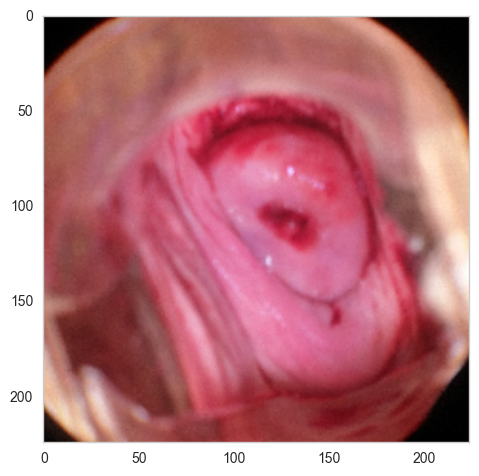

In [3]:
# prepare data
n,h,w,ch = len(df),224,224,3

# function for resizing an image
def read_resize(fpath,h=224,w=224,ch=3):
    im = Image.open(fpath)
    w_im, h_im = im.size
    if w_im < h_im: # general case
        mid_h = h_im/2
        half_w = w_im/2
        bbox = (0,mid_h-half_w,w_im,mid_h+half_w)
    else:
        print(fpath + ' is wide not long')
        mid_w = w_im/2
        half_h = h_im/2
        bbox = (mid_w-half_h,0,mid_w+half_h,h_im)
    im_sml = im.crop(bbox).resize((w,h))
    return np.asarray(im_sml)

# pre-process input for VGG16
def scale_pixels(im):
    im[:, :, :, 0] -= 103.939
    im[:, :, :, 1] -= 116.779
    im[:, :, :, 2] -= 123.68
    # 'RGB'->'BGR'
    im = im[:, :, :, ::-1]
    return im

# plot a sample cropped and resized image
fpath = df.fpath.iloc[0]
im = read_resize(fpath,h,w,ch)
plt.imshow(im)

Let's try out a few exposure-related augmentations on a random subset of our images:

 - brightening
 - contrast adjustments (sigmoid and gamma)
 - CLAHE histogram equalization

In [4]:
# get a random set of 15 pictures for each type

s = 15 # number of random pictures per type
f1 = df[df.category == 'Type_1'].sample(n=s,random_state=1).fpath
f2 = df[df.category == 'Type_2'].sample(n=s,random_state=1).fpath
f3 = df[df.category == 'Type_3'].sample(n=s,random_state=1).fpath
f = pd.concat([f1,f2,f3])

images/train/Type_1/334.jpg is wide not long


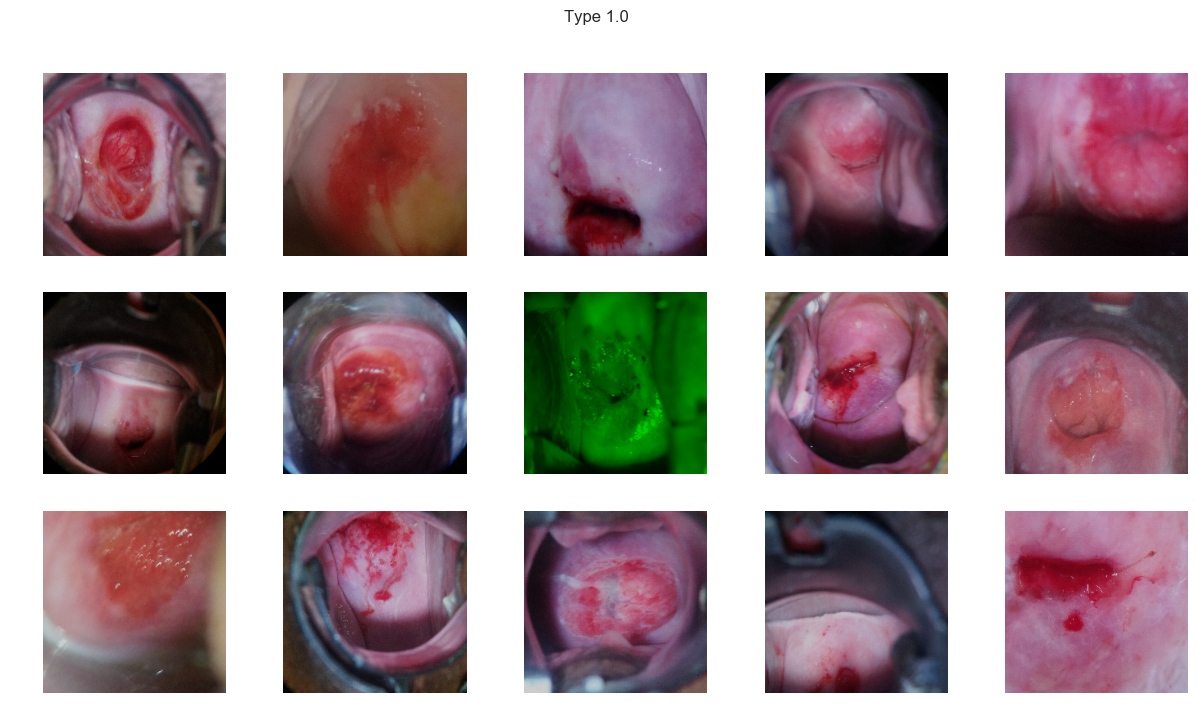

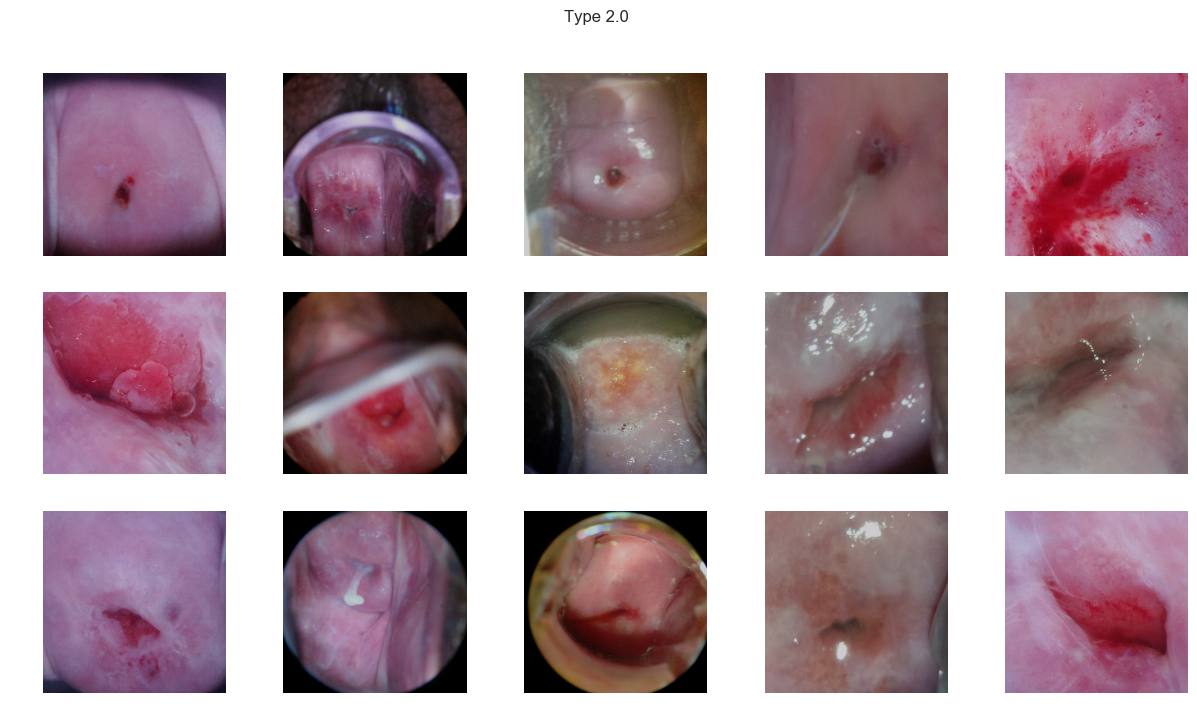

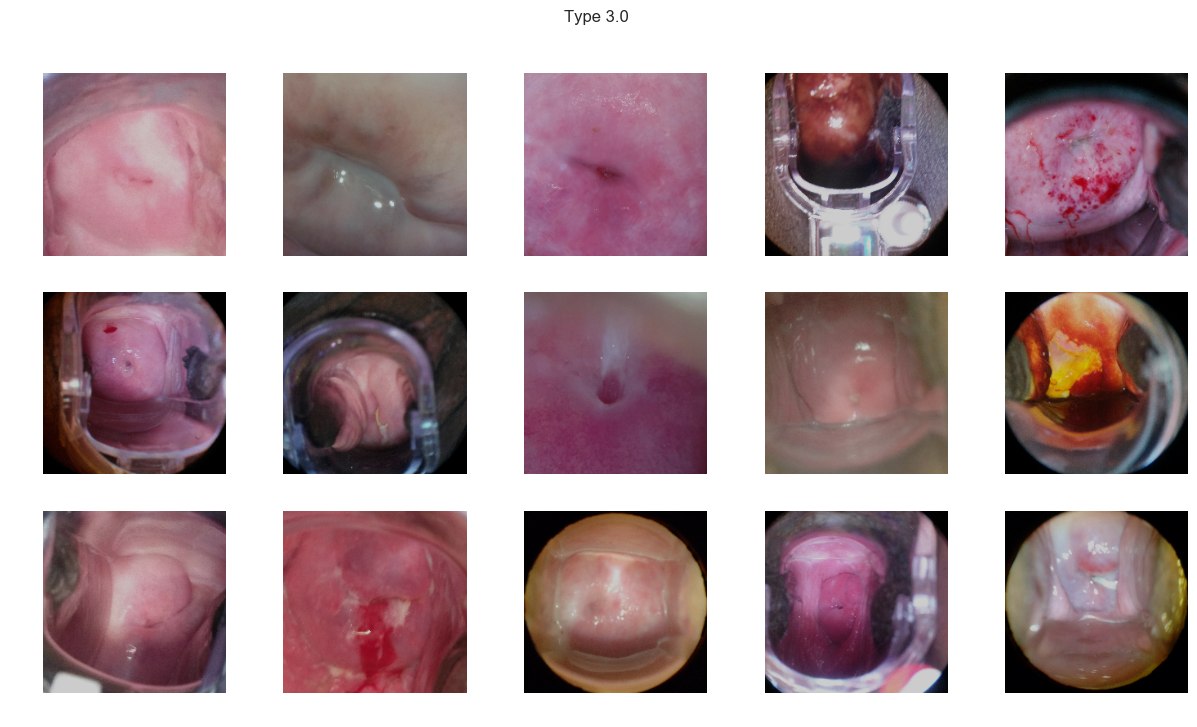

In [5]:

def brighten(im,factor):
    return np.clip(im*factor,a_max=255.,a_min=0.)

brightening_factor = 0.8
for i in range(len(f)):
    if i % 15 == 0:
        fig = plt.figure(figsize=(15,8))
        type_i = 'Type ' + str(i/15+1)
        plt.suptitle(type_i)
    ax = plt.subplot(3,s/3,(i%15)+1)
    im = read_resize(f.iloc[i])
    ax.imshow(brighten(im,brightening_factor)/255) # rescale to (0,1) since we have floats now
    ax.axis('off')

/Users/jingpingw/anaconda/lib/python3.5/site-packages/skimage/util/dtype.py:110: UserWarning: Possible precision loss when converting from float64 to uint16
  "%s to %s" % (dtypeobj_in, dtypeobj))


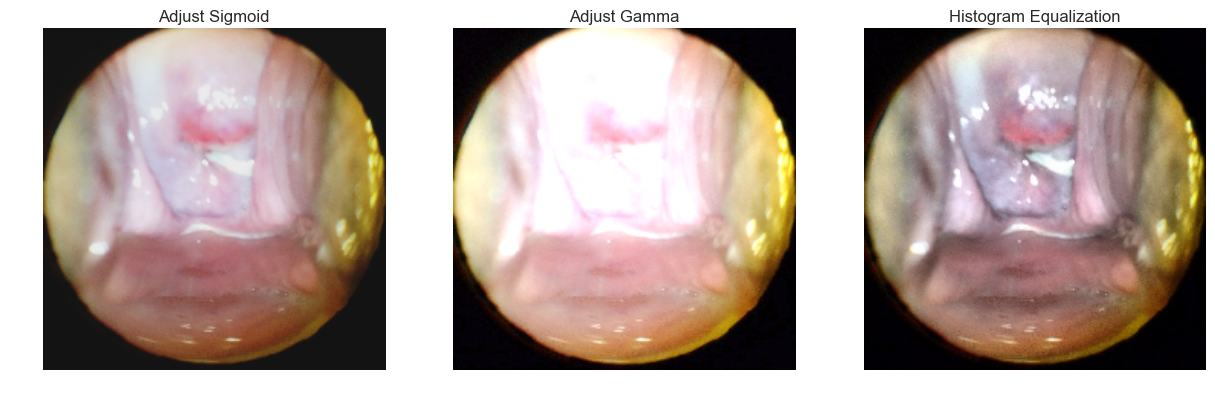

In [6]:
from skimage.exposure import adjust_gamma, adjust_sigmoid, equalize_adapthist

fig = plt.figure(figsize=(15,5))

# adjust_sigmoid
plt.subplot(131)
plt.axis('off')
plt.title('Adjust Sigmoid')
plt.imshow(adjust_sigmoid(im,cutoff=0.5,gain=5)) # feel free to play around with the cutoff and gain

# adjust_gamma
plt.subplot(132)
plt.axis('off')
plt.title('Adjust Gamma')
plt.imshow(np.clip(adjust_gamma(im/255,gamma=0.8,gain=1.3),a_max=1.,a_min=0.))

# equalize_adapthist
plt.subplot(133)
plt.axis('off')
plt.title('Histogram Equalization')
plt.imshow(equalize_adapthist(im))

Overall it would be safe to say that exposure related augmentations aren't very crucial to our datasets, and sometimes even change the actual colour which might lead to a change of diagnosis.

With that we proceed to extract the features, and build a classifier on top of it as a starting benchmark.

In [7]:
# prepare model feature extractors
from keras.applications.vgg16 import VGG16

vgg_none = VGG16(include_top=False, weights='imagenet', input_shape=None, pooling=None)

print('vgg_none output_shape: ' + str(vgg_none.output_shape))

Using TensorFlow backend.


vgg_none output_shape: (None, None, None, 512)


In [8]:
# read in data
X = np.zeros((n,h,w,ch))

for i in df.index:
    fpath = df.ix[i,'fpath']
    x = read_resize(fpath,h,w,ch)
    X[i,...] = x
    if i%100==0:
        print('Read %ith image' % i)

X = scale_pixels(X)

Read 0th image
Read 100th image
images/train/Type_1/334.jpg is wide not long
images/train/Type_1/469.jpg is wide not long
images/train/Type_1/471.jpg is wide not long
images/train/Type_1/582.jpg is wide not long
Read 200th image
images/train/Type_1/880.jpg is wide not long
images/train/Type_2/1006.jpg is wide not long
Read 300th image
images/train/Type_2/1102.jpg is wide not long
images/train/Type_2/1138.jpg is wide not long
images/train/Type_2/1144.jpg is wide not long
Read 400th image
Read 500th image
images/train/Type_2/1421.jpg is wide not long
images/train/Type_2/1444.jpg is wide not long
Read 600th image
images/train/Type_2/276.jpg is wide not long
images/train/Type_2/29.jpg is wide not long
images/train/Type_2/301.jpg is wide not long
images/train/Type_2/303.jpg is wide not long
images/train/Type_2/326.jpg is wide not long
Read 700th image
images/train/Type_2/429.jpg is wide not long
Read 800th image
images/train/Type_2/615.jpg is wide not long
images/train/Type_2/662.jpg is wid

In [9]:
# let's convert our text categories into a vector of integer classes
Y = df.fpath.str.extract('images/train/Type_([0-9]*)/', expand=False).astype(np.int8)
Y.head()

0    1
1    1
2    1
3    1
4    1
Name: fpath, dtype: int8

In [10]:
%%time
features_train = vgg_none.predict(X)
print(features_train.shape)

(1480, 7, 7, 512)
CPU times: user 1h 4min 22s, sys: 4min 49s, total: 1h 9min 12s
Wall time: 19min 12s


Next, we do the same for the images in our test set.

In [11]:
submit_img = glob('images/test/*')
n_test = len(submit_img)
X_submit = np.zeros((n_test,h,w,ch))

for i in range(n_test):
    fpath = submit_img[i]
    x = read_resize(fpath,h,w,ch)
    X_submit[i,...] = x
    if i%100==0:
        print('Read %ith image' % i)

X_submit = scale_pixels(X_submit)

Read 0th image
images/test/154.jpg is wide not long
images/test/16.jpg is wide not long
images/test/160.jpg is wide not long
images/test/188.jpg is wide not long
Read 100th image
images/test/196.jpg is wide not long
images/test/203.jpg is wide not long
images/test/243.jpg is wide not long
images/test/277.jpg is wide not long
Read 200th image
images/test/284.jpg is wide not long
images/test/331.jpg is wide not long
Read 300th image
images/test/423.jpg is wide not long
images/test/429.jpg is wide not long
images/test/447.jpg is wide not long
Read 400th image
images/test/460.jpg is wide not long
images/test/58.jpg is wide not long
images/test/74.jpg is wide not long
images/test/81.jpg is wide not long
Read 500th image


In [12]:
%%time
features_submit = vgg_none.predict(X_submit)
print(features_submit.shape)

(512, 7, 7, 512)
CPU times: user 22min 42s, sys: 1min 41s, total: 24min 24s
Wall time: 6min 46s


We save our data into a hdf5 file, for faster reading in the future.

In [13]:
# save our input image array
f = h5py.File("data/train.h5", "w")
dX_train = f.create_dataset("train/img_cropped_resized_scaled", (n,h,w,ch), dtype='float64')
dX_train[...] = X

dX_submit = f.create_dataset("submit/img_cropped_resized_scaled", (n_test,h,w,ch), dtype='float64')
dX_submit[...] = X_submit

# save labels
dY = f.create_dataset("train/Y", (n,), dtype='int8')
dY[...] = Y

# save our features
df_train = f.create_dataset("train/X", (n,7,7,512), dtype='float64')
df_train[...] = features_train

df_submit = f.create_dataset("submit/X", (n_test,7,7,512), dtype='float64')
df_submit[...] = features_submit

f.close()